<a href="https://colab.research.google.com/github/sahil3Vedi/digit-recogniser-py/blob/master/Deep_Learning_on_MNIST_without_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#declaring all the dependencies NO KERAS OR TENSORFLOW
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
from google.colab import drive
from math import e
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network is Trained in 4 Stages:

1) Network recieves input from model
FUNCTION: NN.getInput(model.inputList)
VARIABLES INVOLVED: NN.layers[0].inputVals

2) Network activates one layer after the other.
FUNCTION: NN.activate(activationFunction)
VARIABLES INVOLVED: NN.layers[i].inputVals, NN.layers[i].activations, NN.layers[i].activDerivates, NN.layers[i].layerWeights, NN.layers[i].bias, NN.layers[i].biasWeights

3) Model calculates cost from the target value of input data and answer provided by network.
FUNCTION: model.getCost(NN)
VARIABLES INVOLVED: NN.layers[-1].activations, NN.layers[-1].forwardError, model.cost

4) Network readjusts the weights based on the cost and error information.
FUNCTION: NN.backpropagate()
VARIABLES INVOLVED: NN.layers[i].forwardError, NN.layers[i].diffWeights, NN.layers[i].diffBias, NN.layers[i-1].activations, NN.layers[i-1].forwardError

In [0]:
class neuralNetwork:
  layers=[]
  finalError=[]
  inputElem=0
  hiddenElem=0
  outputElem=0
  
  #When a neural network is declared 
  def __init__(self):
    self.inputElem=784
    self.outputElem=10
    self.hiddenElem=30
    
    inputLayer = layer(self.inputElem,"normalize",None)
    self.layers.append(inputLayer)
    
    temp = layer(self.hiddenElem,"tanH",self.layers[0])
    self.layers.append(temp)
    temp = layer(self.hiddenElem,"tanH",self.layers[1])
    self.layers.append(temp)
    #temp = layer(self.hiddenElem,"tanH",self.layers[2])
    #self.layers.append(temp)
    
    outputLayer = layer(self.outputElem,"sigmoid",self.layers[2])
    self.layers.append(outputLayer)
    #TOTAL 5 LAYERS
    print("Neural Network Initialised...")
    
  def getInput(self,i):
    self.layers[0].inputVals=i
    
  def dropout(self,x,y):
    stu=[]
    tempp=[]
    tempq=[]
    for i in range(len(x)):
      k=np.random.random_sample()
      m=x[i]
      n=y[i]
      if k<0:
        tempp.append(0)
        tempq.append(0)
      else:
        tempp.append(m)
        tempq.append(n)
    stu.append(tempp)
    stu.append(tempq)
    return stu
    
  def activate(self):
    for i in range(0,len(self.layers)):
      temp=self.layers[i].inputVals
      activation=self.layers[i].activation
      
      if (activation=="normalize"):#typically used for the input layer. if you ask me it makes perfect sense to treat normalisation as input layer activation.
        temp2=[(-1+(int(x)*2)/255) for x in temp]
        temp3=temp2 #this is because normalise is only being used on input layer where we dont need any back prop hence no need to calculate derivative.
      
      if (activation=="ReLU"):
        temp2=[]
        temp3=[]
        for x in temp:
          if (x>0):
            y=x
            z=1
          else:
            y=0.0000001*x
            z=0.0000001
          temp3.append(z)
          temp2.append(y)
          
      if (activation=="tanH"):
        temp2=[]
        temp3=[]
        for x in temp:
          a=e**(0.2*x)
          b=e**(-0.2*x)
          temp2.append((a-b)/(a+b))
        for y in temp2:
          temp3.append(0.2*(1-(y**2)))
          
      if (activation=="sigmoid"):
        temp2=[]
        temp3=[]
        for x in temp:
          sgm=1/(1+e**(-x))
          temp2.append(sgm)
        for y in temp2:
          dev=y*(1-y)
          temp3.append(dev)
          
      if (activation=="softMax"):
        evec=[e**x for x in temp]
        esum=np.sum(evec)
        temp2=[y/esum for y in evec]
        temp3=[q*(1-q) for q in temp2]
        
      if (activation=="tanH" or activation=="ReLU"):  
        stub=self.dropout(temp2,temp3)
      else:
        stub=[]
        stub.append(temp2)
        stub.append(temp3)
      
      self.layers[i].activations=stub[0]
      self.layers[i].activDerivatives=stub[1]
      
      if(i!=len(self.layers)-1):#this is because we dont need to feed forward beyond the output layer.
        self.layers[i].feedForward(self.layers[i+1])
  
  def backpropagate(self):
    for i in range(len(self.layers)):
      ind=-i-1
      if(i!=len(self.layers)-1):
        self.layers[ind].updateWeights(self.layers[ind-1])

In [0]:
class model:
  BN=[]
  maxAccuracy=0
  epoch=0
  learningRate=0.01
  cost=0
  target=0
  inputFile=[]
  trainingEntries=0
  accuracy=0
  accuracies=[]
  costs=[]
  epochs=[]
  
  def plotLoss(self):
    fig = plt.figure()
    ax = plt.axes()
    bx=plt.axes()
    costs=np.multiply(100,self.costs)
    ax.plot(self.epochs,self.accuracies)
    ax.plot(self.epochs,costs)
    plt.show()
    
  def response(self,NN):
    #updating learning rate
    self.learningRate=(self.cost)*(0.25)/(0.449*(1+(self.epoch/3000)))
    maxI=max(NN.layers[-1].activations)
    indX=NN.layers[-1].activations.index(maxI)
    if(str(self.target)==str(indX)):
      self.accuracy+=1
    self.epoch+=1
    if(self.epoch%7000==0):
      self.plotLoss()
    if(self.epoch%1000==0):
      print("Epoch: " + str(self.epoch) + " Cost: " + str(self.cost) + " Target: " + str((self.target)) + " Answer : " + str(indX))
      #print(NN.layers[-3].activations)
      print("Accuracy: " + str(self.accuracy) + "% Max: " + str(self.maxAccuracy) + "%")
    if(self.epoch%100==0):
      if(self.accuracy>self.maxAccuracy):
        self.BN=[]
        for i in NN.layers:
          self.BN.append(i)
        self.maxAccuracy=self.accuracy
      #Adding accuracy cost and epoch for plotting.
      self.costs.append(self.cost)
      self.accuracies.append(self.accuracy)
      self.epochs.append(self.epoch)
      self.accuracy=0
  
  def getInput(self,inputFile):
    with open(inputFile) as csvFile:
      csvReader = csv.reader(csvFile)
      self.inputFile = list(csvReader)
      self.trainingEntries = len(self.inputFile)-1  #n-1 because first row is header row
      print("Total entries excluding header: " + str(self.trainingEntries) + " rows")
      
  def getCost(self,NN):
    targetVector=[]
    for i in range(10):
      if (str(i)==str(self.target)):
        targetVector.append(1)
      else:
        targetVector.append(0)
    output=NN.layers[-1].activations
    error=[x-y for (x,y) in zip(output,targetVector)]
    self.cost=0.5*(np.sum(np.square(error)))
    NN.layers[-1].forwardError=error
      
  def trainNetwork(self,NN):
    inputList=self.inputFile
    inputList.pop(0)
    for i in inputList:
      self.target=i[0]
      i.pop(0)
      NN.getInput(i)
      NN.activate()
      self.getCost(NN)
      NN.backpropagate()
      Model.response(NN)
      
  def invCross(self,l1,l2): #this is the ONLY part that
    temp=[]
    for x in l1:
      temptemp=[]
      for y in l2:
        temptemp.append(x*y)
      temp.append(temptemp)
    return temp
      

In [0]:
class layer:
  numberElements=0
  bias=0
  activation="default"
  inputVals=[]
  activations=[]
  activDerivatives=[]
  forwardError=[]
  layerWeights=[]
  biasWeights=[]
  
  #When a layer is declared
  def __init__(self,no_of_elements,activation,previousLayer):
    self.numberElements=no_of_elements
    self.bias=0.1
    self.activation=activation
    #Initialising the Weight Matrix
    temp=[]
    if(previousLayer!=None):
      for i in range(previousLayer.numberElements):
        temptemp=[]
        for j in range(self.numberElements):
          temptemp.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
        temp.append(temptemp)
    self.layerWeights=temp
    #Initialising the Bias Matrix
    self.biasWeights=[]
    for i in range(self.numberElements):
      self.biasWeights.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
      
  def feedForward(self,nextLayer):
    tempbias=self.bias
    biasVec=nextLayer.biasWeights
    temp2=np.matmul(self.activations,nextLayer.layerWeights)
    temp3=np.multiply(tempbias,biasVec)
    nextLayer.inputVals=[x+y for (x,y) in zip(temp2,temp3)]
    
  def updateWeights(self,prevLayer):
    #declaring the Differential diagonal matrix
    dmx=[]
    for i in range(self.numberElements):
      dtemp=[]
      oi=self.activations[i]
      for j in range(self.numberElements):
        if(i==j):
          dtemp.append(oi*(1-oi))
        else:
          dtemp.append(0)
      dmx.append(dtemp)
    #declaring do vector
    dovec=np.matmul(dmx,self.forwardError)
    wmx=Model.invCross(dovec,prevLayer.activations)
    bvec=np.multiply((self.bias*Model.learningRate),dovec)
    wMx=np.multiply(Model.learningRate,wmx)
    tempW=np.subtract(self.layerWeights,np.transpose(wMx))
    tempB=np.subtract(self.biasWeights,bvec)
    self.layerWeights=tempW
    prevLayer.forwardError=np.matmul(self.layerWeights,dovec)
    
    

Total entries excluding header: 42000 rows
Neural Network Initialised...
Epoch: 1000 Cost: 0.4609047150377112 Target: 4 Answer : 2
Accuracy: 13% Max: 16%
Epoch: 2000 Cost: 0.4506590189603511 Target: 4 Answer : 1
Accuracy: 16% Max: 16%
Epoch: 3000 Cost: 0.43766391890693446 Target: 3 Answer : 7
Accuracy: 13% Max: 17%
Epoch: 4000 Cost: 0.4596574534676665 Target: 4 Answer : 1
Accuracy: 16% Max: 17%
Epoch: 5000 Cost: 0.4677864100215142 Target: 9 Answer : 3
Accuracy: 12% Max: 17%
Epoch: 6000 Cost: 0.4349523540415085 Target: 0 Answer : 7
Accuracy: 16% Max: 26%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


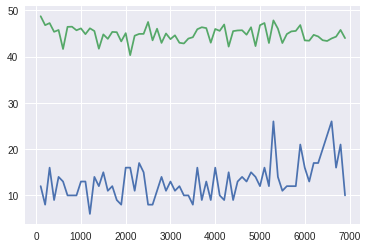

Epoch: 7000 Cost: 0.44692128276451043 Target: 9 Answer : 7
Accuracy: 18% Max: 26%
Epoch: 8000 Cost: 0.4503971383202904 Target: 3 Answer : 1
Accuracy: 24% Max: 26%
Epoch: 9000 Cost: 0.45302306997772573 Target: 9 Answer : 1
Accuracy: 25% Max: 27%
Epoch: 10000 Cost: 0.45008147140826027 Target: 9 Answer : 7
Accuracy: 24% Max: 28%
Epoch: 11000 Cost: 0.4676474699969874 Target: 9 Answer : 4
Accuracy: 30% Max: 34%
Epoch: 12000 Cost: 0.42789467700232936 Target: 0 Answer : 4
Accuracy: 31% Max: 34%
Epoch: 13000 Cost: 0.39730132549922587 Target: 4 Answer : 4
Accuracy: 35% Max: 36%


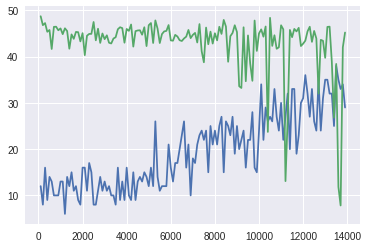

Epoch: 14000 Cost: 0.4454299502849508 Target: 8 Answer : 4
Accuracy: 35% Max: 38%
Epoch: 15000 Cost: 0.45302914267881544 Target: 6 Answer : 3
Accuracy: 30% Max: 38%
Epoch: 16000 Cost: 0.44442589273588023 Target: 6 Answer : 2
Accuracy: 35% Max: 42%
Epoch: 17000 Cost: 0.39469943570914306 Target: 7 Answer : 9
Accuracy: 37% Max: 46%
Epoch: 18000 Cost: 0.21254137046774382 Target: 0 Answer : 0
Accuracy: 47% Max: 48%
Epoch: 19000 Cost: 0.36174057851794367 Target: 2 Answer : 2
Accuracy: 41% Max: 52%
Epoch: 20000 Cost: 0.25471602411573324 Target: 7 Answer : 7
Accuracy: 46% Max: 56%


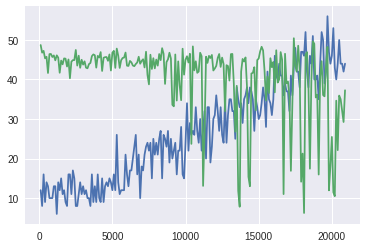

Epoch: 21000 Cost: 0.399475401259267 Target: 4 Answer : 0
Accuracy: 42% Max: 56%
Epoch: 22000 Cost: 0.10224347703862871 Target: 1 Answer : 1
Accuracy: 50% Max: 56%
Epoch: 23000 Cost: 0.4072032131914455 Target: 8 Answer : 8
Accuracy: 54% Max: 56%
Epoch: 24000 Cost: 0.043974559375720104 Target: 1 Answer : 1
Accuracy: 39% Max: 58%
Epoch: 25000 Cost: 0.4586886932169551 Target: 5 Answer : 2
Accuracy: 57% Max: 59%
Epoch: 26000 Cost: 0.4119463324879565 Target: 3 Answer : 3
Accuracy: 53% Max: 60%
Epoch: 27000 Cost: 0.34598451969449345 Target: 9 Answer : 9
Accuracy: 47% Max: 66%


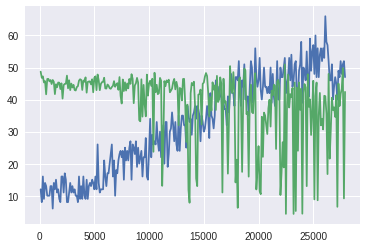

Epoch: 28000 Cost: 0.1973549118862369 Target: 7 Answer : 7
Accuracy: 39% Max: 66%
Epoch: 29000 Cost: 0.4660173624173706 Target: 5 Answer : 1
Accuracy: 63% Max: 66%
Epoch: 30000 Cost: 0.09206367080291983 Target: 0 Answer : 0
Accuracy: 43% Max: 66%
Epoch: 31000 Cost: 0.3899438028789234 Target: 4 Answer : 9
Accuracy: 47% Max: 66%
Epoch: 32000 Cost: 0.454896082466954 Target: 0 Answer : 9
Accuracy: 52% Max: 66%
Epoch: 33000 Cost: 0.15540798318914809 Target: 7 Answer : 7
Accuracy: 54% Max: 66%
Epoch: 34000 Cost: 0.38053863238121005 Target: 9 Answer : 9
Accuracy: 55% Max: 66%


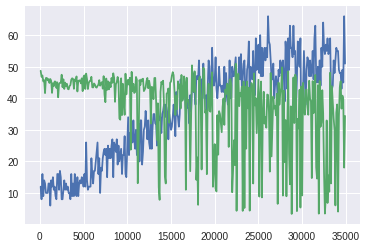

Epoch: 35000 Cost: 0.17269963447942402 Target: 0 Answer : 0
Accuracy: 59% Max: 66%
Epoch: 36000 Cost: 0.3831248030080334 Target: 4 Answer : 9
Accuracy: 55% Max: 66%
Epoch: 37000 Cost: 0.45756206480287304 Target: 5 Answer : 6
Accuracy: 44% Max: 66%
Epoch: 38000 Cost: 0.052373638359848616 Target: 0 Answer : 0
Accuracy: 50% Max: 66%
Epoch: 39000 Cost: 0.4713943889966148 Target: 9 Answer : 6
Accuracy: 51% Max: 66%
Epoch: 40000 Cost: 0.44388909844931135 Target: 3 Answer : 0
Accuracy: 43% Max: 66%
Epoch: 41000 Cost: 0.3589137113651221 Target: 6 Answer : 6
Accuracy: 29% Max: 66%


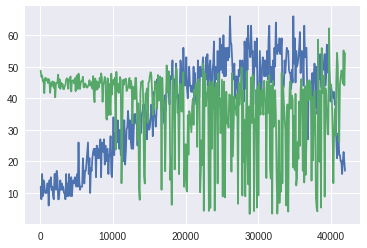

Epoch: 42000 Cost: 0.4811655669361303 Target: 9 Answer : 2
Accuracy: 18% Max: 66%
[]
[[ 1.00004096  1.85720296  0.43827287 ... -0.02539956 -0.0778908
   0.09155103]
 [ 0.95129938  1.86867103  0.56591322 ... -0.15306458 -0.10059053
   0.06405592]
 [ 1.0998307   1.8606057   0.33766396 ... -0.06407347 -0.04827912
   0.09348999]
 ...
 [ 1.02451454  1.81236494  0.49556073 ... -0.1572434   0.08205588
   0.26083265]
 [ 0.90004048  1.83742919  0.36976525 ... -0.04441924  0.03547567
   0.30314647]
 [ 1.00952349  1.87232932  0.41373057 ... -0.00700272 -0.12926579
   0.25370958]]
[[-6.94711447e-01 -7.15912269e-01  2.79120541e-02 -2.84057216e-02
   1.02508577e+00 -3.92752671e-01 -4.90892333e-01  4.50286647e-03
   4.76552101e-02  1.02883777e-01 -5.61593707e-02  7.07848694e-01
   5.67248395e-01  1.02769960e-01  1.44902231e-01  1.77753090e-01
   5.76098870e-01 -9.55996695e-02  4.97113477e-02  7.01655738e-04
   1.38326114e-01  1.07531113e-01 -2.85330158e-02  6.79936887e-01
  -1.03107833e-01 -1.2692189

In [10]:
#-----MAIN FUNCTION-----

Model = model()
inputFile='drive/My Drive/MNIST Image CSV/train.csv'
Model.getInput(inputFile)

NN = neuralNetwork()
Model.trainNetwork(NN)

for i in Model.BN:
  print(i.layerWeights)